In [ ]:
# https://platform.openai.com/docs/tutorials/web-qa-embeddings

In [57]:
import requests
import re
import tiktoken
import pandas as pd
import os

In [58]:
url = "https://www.gov.uk/api/content/foreign-travel-advice"
base_url = "https://www.gov.uk/api/content"

In [59]:
# A function to extract the list of individual country api urls
def url_list(url):
    response = requests.get(url).json()
    list_of_urls = [i["base_path"] for i in response["links"]["children"]]
    return list_of_urls

In [60]:
# functions to clean text from api
def remove_text_between_angle_brackets(input_string):
    pattern = r'<.*?>'  # This pattern matches everything between angle brackets
    result = re.sub(pattern, '', input_string)
    return result

def remove_newlines(serie):
    serie = serie.replace('\n', ' ')
    serie = serie.replace('\\n', ' ')
    serie = serie.replace('  ', ' ')
    serie = serie.replace('   ', ' ')
    return serie

In [61]:
# a function to extract the text from each country on the fco government advice page and save them into individual text files

def crawl():
    # get a list of the api urls
    api_url_list = url_list(url)

    # Create a directory to store the text files
    if not os.path.exists("raw_data/"):
            os.mkdir("raw_data/")

    if not os.path.exists("raw_data/"):
            os.mkdir("raw_data/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # iterate through url list to get all the text for every country
    for country in api_url_list:                                                 # only 5 countries as a trial
        

        # Save text from the url to a country.txt file
        with open('raw_data/'+ country[23:] + ".txt", "w", encoding="UTF-8") as f:
            
            print(country[23:])
            
            # create api url
            country_url = base_url + country
            
            # make request to api
            response = requests.get(country_url).json()
            
            # extract and clean text for the country
            text = ''
            for part in response["details"]["parts"]:
                part = remove_text_between_angle_brackets(part['body'])
                part = remove_newlines(part)
                text+=part

            # write the text to the file in the text directory
            f.write(text)

crawl()

singapore
british-indian-ocean-territory
samoa
malaysia
french-polynesia
united-arab-emirates
uzbekistan
maldives
marshall-islands
micronesia
solomon-islands
armenia
czech-republic
nauru
tonga
belgium
san-marino
new-caledonia
timor-leste
wallis-and-futuna
slovakia
finland
turkmenistan
mayotte
bulgaria
kazakhstan
kiribati
bonaire-st-eustatius-saba
kyrgyzstan
bahrain
laos
cayman-islands
costa-rica
cuba
iran
turks-and-caicos-islands
curacao
romania
anguilla
liechtenstein
luxembourg
gabon
oman
the-gambia
syria
qatar
kuwait
bolivia
guinea
antarctica-british-antarctic-territory
antigua-and-barbuda
mauritania
chile
el-salvador
grenada
guadeloupe
guatemala
haiti
panama
aruba
western-sahara
falkland-islands
honduras
jamaica
st-kitts-and-nevis
martinique
yemen
guyana
st-maarten
guinea-bissau
cameroon
st-martin-and-st-barthelemy
malawi
rwanda
bahamas
lesotho
st-pierre-and-miquelon
sao-tome-and-principe
liberia
benin
botswana
cape-verde
azerbaijan
french-guiana
paraguay
mauritius
chad
zambia
st-he

In [62]:
#create a df from the stored text files

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("raw_data/"):

    # Open the file and read the text
    with open("raw_data/" + file, "r", encoding="UTF-8") as f:
        text = f.read()

        # append text to list.
        texts.append((file[:-4], text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# # Set the text column to be the raw text with the newlines removed
df.to_csv('processed/scraped.csv')
df.head()

,fname,text
0,curacao,"Before you travel, check the ‘Entry requireme..."
1,andorra,"The Foreign, Commonwealth &amp; Development Of..."
2,haiti,"The Foreign, Commonwealth &amp; Development Of..."
3,finland,"Before you travel, check the ‘Entry requireme..."
4,british-virgin-islands,As the British Virgin Islands (BVI) is a Brit...


<AxesSubplot:>

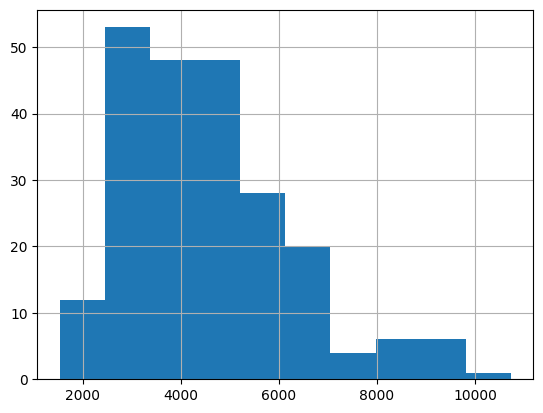

In [63]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [64]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]

    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks


shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])

    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<AxesSubplot:>

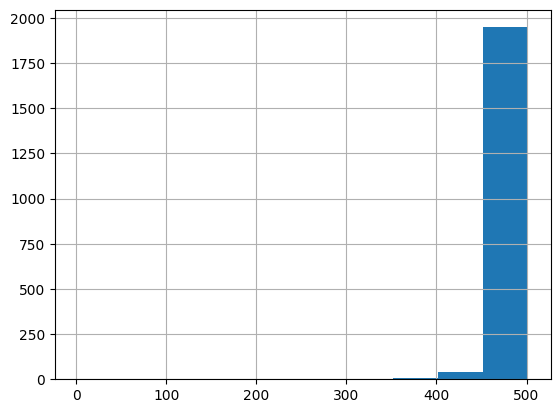

In [65]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [68]:
import openai

openai.api_key = os.getenv("OPENAI_API_KEY")

df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])

df.to_csv('processed/embeddings.csv')
df.head()

,text,n_tokens,embeddings
0,"Before you travel, check the ‘Entry requireme...",492,"[0.011368561536073685, 0.008990953676402569, 0..."
1,Plan ahead and make sure you: can access money...,477,"[0.020920364186167717, 0.009736730717122555, 0..."
2,"However, the International Air Transport Assoc...",500,"[0.006420987192541361, -0.004806826822459698, ..."
3,If you’re transiting through Curaçao Transitin...,497,"[0.02678772248327732, 0.015563013963401318, 0...."
4,"While travel can be enjoyable, it can sometime...",491,"[0.010565687902271748, 0.011830685660243034, 0..."


In [69]:
import numpy as np
from openai.embeddings_utils import distances_from_embeddings

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,"Before you travel, check the ‘Entry requireme...",492,"[0.011368561536073685, 0.008990953676402569, 0..."
1,Plan ahead and make sure you: can access money...,477,"[0.020920364186167717, 0.009736730717122555, 0..."
2,"However, the International Air Transport Assoc...",500,"[0.006420987192541361, -0.004806826822459698, ..."
3,If you’re transiting through Curaçao Transitin...,497,"[0.02678772248327732, 0.015563013963401318, 0...."
4,"While travel can be enjoyable, it can sometime...",491,"[0.010565687902271748, 0.011830685660243034, 0..."


In [70]:
def create_context(
    question, df, max_len=1800, size="ada"
    ):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():

        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4

        # If the context is too long, break
        if cur_len > max_len:
            break

        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

In [71]:
def answer_question(
    df,
    model="text-davinci-003",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [74]:
answer_question(df, question="How do I apply for a visa for the USA?")

'You will need either an Electronic System for Travel Authorisation (ESTA) visa waiver or a visa to enter or transit the USA as a visitor. You can apply for an ESTA visa waiver on the US State Department website. To apply for a US visa, visit the US Embassy for details on how to apply.'